Check out the test repo and figure out which time steps have data

In [1]:
import icechunk as ic
import xarray as xr

storage = ic.s3_storage(
    bucket="/nasa-waterinsight",
    prefix="virtual-zarr-store/NLDAS-3-icechunk/",
    anonymous=True,
)
config = ic.Repository.fetch_config(storage=storage)
vchunk_containers = config.virtual_chunk_containers.keys()
container_credentials = ic.containers_credentials(
    {k: ic.s3_credentials(anonymous=True) for k in vchunk_containers}
)
repo = ic.Repository.open(
    storage=storage, authorize_virtual_chunk_access=container_credentials
)
session = repo.readonly_session("main")
ds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)

/Users/juliusbusecke/Code/titiler-multidim/.venv/lib/python3.12/site-packages/zarr/codecs/numcodecs/_codecs.py:139: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


In [2]:
ds

<xarray.Dataset> Size: 51TB
Dimensions:   (time: 8399, lat: 6500, lon: 11700)
Coordinates:
  * time      (time) datetime64[ns] 67kB 2001-01-02 2001-01-03 ... 2024-01-01
  * lat       (lat) float64 52kB 7.005 7.015 7.025 7.035 ... 71.97 71.98 71.99
  * lon       (lon) float64 94kB -169.0 -169.0 -169.0 ... -52.03 -52.01 -52.0
Data variables:
    Rainf     (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Tair_max  (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Wind_N    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    LWdown    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    SWdown    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Qair      (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Tair      (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    PSurf     (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Tair_min  (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Wind_E    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        daily
    shortname:              NLDAS_FOR0010_D_3.0
    title:                  NLDAS Forcing Data L4 Daily 0.01 x 0.01 degree V3...
    version:                3.0 beta
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/v3/ ; https://li...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  7.005000114440918
    SOUTH_WEST_CORNER_LON:  -168.9949951171875
    DX:                     0.009999999776482582
    DY:                     0.009999999776482582

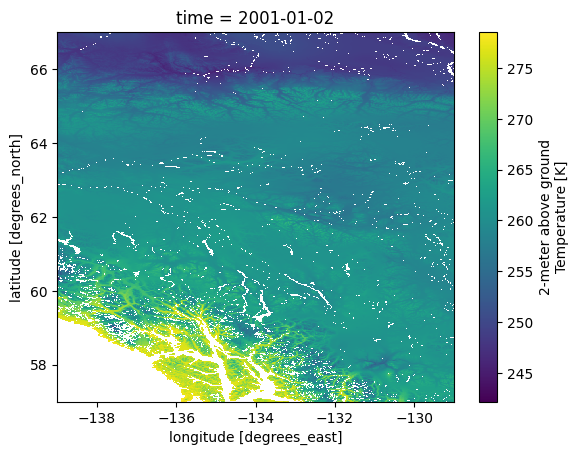

In [3]:
ds["Tair"].isel(lon=slice(3000, 4000), lat=slice(5000, 6000), time=0).plot()

## Test the tilejson endpoint 

Adopted from https://github.com/developmentseed/titiler-cmr/blob/develop/docs/examples/xarray_backend_example.ipynb

In [6]:
import json

import httpx
import xarray as xr
from folium import Map, TileLayer

titiler_endpoint = (
    "https://syonjbeb09.execute-api.us-west-2.amazonaws.com"  # dev endpoint
)


variable = "Tair"
datetime_ = ds.time.values[0]
url = "s3://nasa-waterinsight/virtual-zarr-store/NLDAS-3-icechunk/"

In [10]:
r = httpx.get(
    f"{titiler_endpoint}/WebMercatorQuad/tilejson.json",
    params=(
        ("url", url),
        # ("decode_times", True),
        # ("datetime", datetime_),
        ("variable", variable),
        ("rescale", "270,300"),
        ("colormap_name", "blues_r"),
        # ("sel_method", "nearest"),
    ),
).json()

print(r)

{'tilejson': '2.2.0', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['https://syonjbeb09.execute-api.us-west-2.amazonaws.com/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=s3%3A%2F%2Fnasa-waterinsight%2Fvirtual-zarr-store%2FNLDAS-3-icechunk%2F&variable=Tair&rescale=270%2C300&colormap_name=blues_r'], 'minzoom': 1, 'maxzoom': 7, 'bounds': [-168.9999951170962, 7.000000114825381, -51.99999725350927, 71.99999511680303], 'center': [-110.49999618530273, 39.49999761581421, 1]}


In [11]:
bounds = r["bounds"]
m = Map(location=(70, -40), zoom_start=3)

TileLayer(
    tiles=r["tiles"][0],
    opacity=1,
    attr="NASA",
).add_to(m)
m

In [6]:
geojson_dict = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "coordinates": [
                    [
                        [-20.79973248834736, 83.55979308678764],
                        [-20.79973248834736, 75.0115425216471],
                        [14.483337068956956, 75.0115425216471],
                        [14.483337068956956, 83.55979308678764],
                        [-20.79973248834736, 83.55979308678764],
                    ]
                ],
                "type": "Polygon",
            },
        }
    ],
}

r = httpx.post(
    f"{titiler_endpoint}/statistics",
    params=(
        ("url", url),
        ("datetime", datetime_),
        ("variable", variable),
    ),
    json=geojson_dict,
    timeout=60,
).json()

print(json.dumps(r, indent=2))

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -20.79973248834736,
              83.55979308678764
            ],
            [
              -20.79973248834736,
              75.0115425216471
            ],
            [
              14.483337068956956,
              75.0115425216471
            ],
            [
              14.483337068956956,
              83.55979308678764
            ],
            [
              -20.79973248834736,
              83.55979308678764
            ]
          ]
        ]
      },
      "properties": {
        "statistics": {
          "2024-06-02T09:00:00.000000000": {
            "min": 271.34999999999997,
            "max": 279.005,
            "mean": 272.71998336321025,
            "count": 2841063.5,
            "sum": 774814790.4538239,
            "std": 2.1572893578676204,
            "median": 271.